## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

import sys

sys.path.insert(1, "./../")


from pathlib import Path


from settings import config

import level_1_filters as f1
import level_2_filters as f2
import level_3_filters as f3
from datetime import date


import warnings

In [2]:
import plotly.io as pio

pio.templates.default = "plotly_white"
warnings.filterwarnings("ignore")

In [3]:
OUTPUT_DIR = Path(config("OUTPUT_DIR"))
DATA_DIR = Path(config("DATA_DIR"))
WRDS_USERNAME = config("WRDS_USERNAME")

START_DATE_01 = date(1996, 1, 1)
END_DATE_01 = date(2012, 1, 31)

START_DATE_02 = date(2012, 2, 1)
END_DATE_02 = date(2024, 12, 31)

NOTE_START = START_DATE_01
NOTE_END = END_DATE_01

In [4]:
DATE_RANGE = f"{pd.Timestamp(START_DATE_01):%Y-%m}_{pd.Timestamp(END_DATE_02):%Y-%m}"

## Function Definitions

In [5]:
def compare_filtered_data_to_orig(filtered_df, orig_df, filter_name="Identical Filter"):
    print("|", filter_name, ":")
    print(
        f">> Records removed: {orig_df.shape[0] - filtered_df.shape[0]:,.0f} out of {orig_df.shape[0]:,.0f} ({(orig_df.shape[0] - filtered_df.shape[0]) / orig_df.shape[0]:,.2%})"
    )
    print(
        f">> Filtered data shape: {filtered_df.shape[0]:,.0f} rows // {filtered_df.shape[1]:,.0f} columns"
    )

## Data Note

- The original CJS 2013 paper used data from 1986 through 2012 (26 years of data).
- Due to the unavailability of SPX option data from 1985 to 1995, we replicated the **54 CJS portfolios** using data from **January 1996 to December 2019** (23 years).
- Our dataset (from 1996 to 2019) comprises over 19.2 million rows of SPX options data.
- The original effectiveness of the data filters was examined in *The Puzzle of Filtering Index Options (Desai, Hammock, Holt; 2024)*. Due to similar reasons as outlined in that work (loss of data filter elegance when transposed across timeframes), we expect that the data filter parameters (and thus the portfolios constructed) will not yield identical results to the original published work, and the user should not have this expectation. 

*The spirit of this project is to replicate with the highest practical fidelity the *process* of data filtration and portfolio construction in the original CJS and HKM papers, without commenting on the effectiveness or appropriateness of the process and parameters. We leave that analysis to a future study.*

In [6]:
file_path = Path(DATA_DIR / "options" / "data_1996-01_2019-12.parquet")

if file_path.exists():
    print(">> File already exists. Loading data from file...")
    # Load the data from the file
    raw_option_data = pd.read_parquet(file_path)
else:
    print(">> File does not exist. Loading data from WRDS...")
    # Load the data from WRDS
    raw_option_data = pd.concat(
        [
            pd.read_parquet(
                Path(DATA_DIR / "options" / "data_1996-01_2012-01.parquet")
            ),
            pd.read_parquet(
                Path(DATA_DIR / "options" / "data_2012-02_2019-12.parquet")
            ),
        ]
    )
    raw_option_data.to_parquet(file_path)

# add the mid price
raw_option_data["mid_price"] = (
    raw_option_data["best_bid"] + raw_option_data["best_offer"]
) / 2
# adjust strike price
raw_option_data["strike_price"] /= 1000
# calc moneyness
raw_option_data = f1.calc_moneyness(raw_option_data)
# rename IV column
raw_option_data.rename(columns={"impl_volatility": "IV"}, inplace=True)

raw_option_data

>> File already exists. Loading data from file...


,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,NaN,5.04,0.0,1704.0,55.000,56.000,565.0,100.0,55.500,0.914684
1,108105.0,1996-01-04,621.32,617.70,C,1996-01-20,NaN,5.04,0.0,108.0,75.500,76.500,540.0,100.0,76.000,0.874211
2,108105.0,1996-01-05,617.70,616.71,C,1996-02-17,NaN,5.03,500.0,5900.0,57.750,58.750,560.0,100.0,58.250,0.908044
3,108105.0,1996-01-08,616.71,618.46,C,1996-03-16,NaN,5.03,0.0,315.0,145.500,146.500,475.0,100.0,146.000,0.768037
4,108105.0,1996-01-09,618.46,609.45,C,1996-12-21,NaN,5.01,0.0,8.0,188.375,189.375,425.0,100.0,188.875,0.697350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66102,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,944.700,962.900,4200.0,100.0,953.800,1.299996
66103,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1042.000,1060.300,4300.0,100.0,1051.150,1.330948
66104,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1140.000,1158.200,4400.0,100.0,1149.100,1.361900
66105,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1237.900,1256.100,4500.0,100.0,1247.000,1.392853


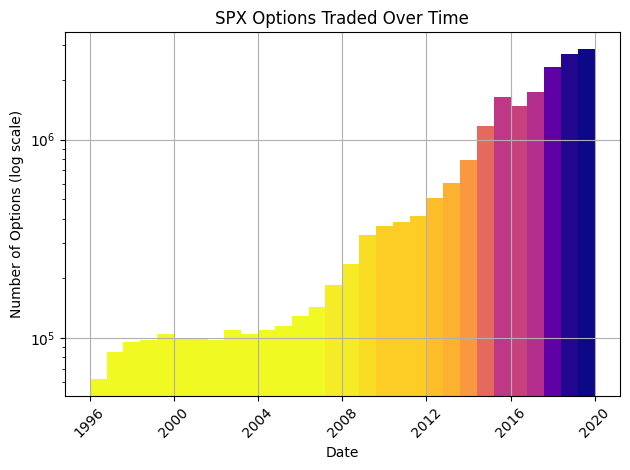

In [7]:
# Histogram parameters
counts, bins, patches = plt.hist(raw_option_data["date"], bins=30)

# Apply plasma_r colormap
cmap = cm.get_cmap("plasma_r", len(patches))
normed = (counts - counts.min()) / (counts.max() - counts.min())
for patch, norm in zip(patches, normed):
    patch.set_facecolor(cmap(norm))

# Labels and aesthetics
plt.xlabel("Date")
plt.yscale("log")
plt.grid()
plt.ylabel("Number of Options (log scale)")
plt.title("SPX Options Traded Over Time")
plt.xticks(rotation=45)
plt.tight_layout()

# Save before show
plt.savefig(OUTPUT_DIR / "spx_options_over_time.png")
plt.show()

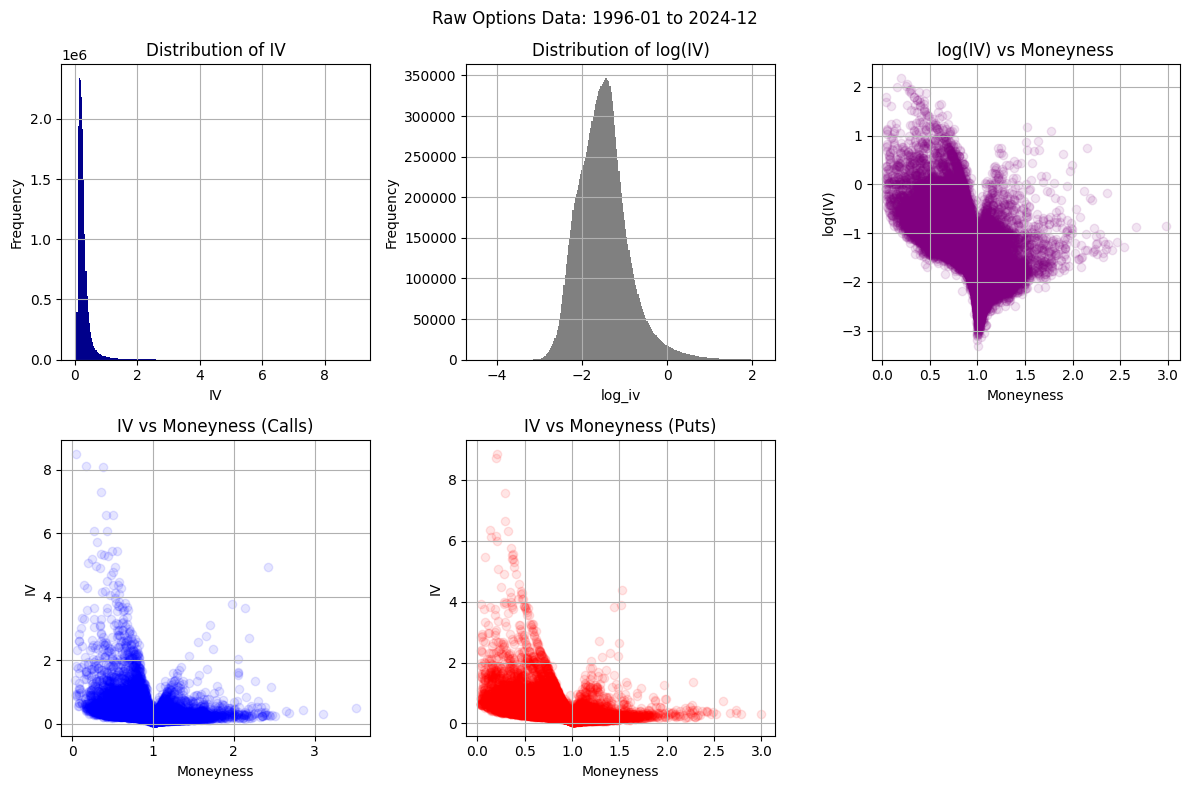

In [8]:
f3.build_raw_iv_chart(raw_option_data, DATE_RANGE)

# 1. Data Filtration

In order to minimize possible quoting errors, CJS filtered the raw options data through 3 levels of filters. The filters are applied to the trade-in (buy) side to make sure the portfolios are buying into reliable quotes. When positions are exited, if there is no quote in the filtered data, the raw data is searched. These filters are detailed in *Appendix B* of CJS. 

## Level 1 Filters

* **Identical Filter:** Retain only one instance of quotes with the same **option type**, **strike price**, **expiration date/maturity**, and **price**. 

* **Identical Except Price Filter:** There are a few sets of quotes with identical terms (**type**, **strike**, and **maturity**) but different prices. Keep the quote whose **T-bill-based implied volatility** is closest to that of its **moneyness neighbors**, and delete the others.  

* **Bid = 0 Filter:** Drop quotes with a **bid price** of zero, thereby avoiding low-valued options. Also, a zero bid may indicate censoring as negative bids cannot be recorded.

* **Volume = 0 Filter:** Drop quotes of zero for volumes. *Note: Appendix B of CJS does not explicitly detail this filter, but we include it here since it is included in *Table B.1. Filters* of CJS.*  



### Identical Filter

We drop records with identical **option type, strike, expiration date, and price**. In each such case, we eliminate all but one of the quotes. 

In [9]:
spx_filtered = f1.identical_filter(raw_option_data)
spx_filtered

,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,NaN,5.04,0.0,1704.0,55.000,56.000,565.0,100.0,55.500,0.914684
1,108105.0,1996-01-04,621.32,617.70,C,1996-01-20,NaN,5.04,0.0,108.0,75.500,76.500,540.0,100.0,76.000,0.874211
2,108105.0,1996-01-05,617.70,616.71,C,1996-02-17,NaN,5.03,500.0,5900.0,57.750,58.750,560.0,100.0,58.250,0.908044
3,108105.0,1996-01-08,616.71,618.46,C,1996-03-16,NaN,5.03,0.0,315.0,145.500,146.500,475.0,100.0,146.000,0.768037
4,108105.0,1996-01-09,618.46,609.45,C,1996-12-21,NaN,5.01,0.0,8.0,188.375,189.375,425.0,100.0,188.875,0.697350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66102,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,944.700,962.900,4200.0,100.0,953.800,1.299996
66103,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1042.000,1060.300,4300.0,100.0,1051.150,1.330948
66104,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1140.000,1158.200,4400.0,100.0,1149.100,1.361900
66105,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1237.900,1256.100,4500.0,100.0,1247.000,1.392853


In [10]:
compare_filtered_data_to_orig(spx_filtered, raw_option_data, "Identical Filter")

| Identical Filter :
>> Records removed: 277,102 out of 19,213,898 (1.44%)
>> Filtered data shape: 18,936,796 rows // 16 columns


### Identical Except Price Filter

We drop records with **identical terms (type, strike, and maturity) but different prices**. Retained quotes are those whose T-bill-based implied volatility is closest to that of its moneyness neighbors, and delete the others. 

In [11]:
spx_filtered_2 = f1.identical_but_price_filter(spx_filtered)
spx_filtered_2

,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,NaN,5.04,0.0,1704.0,55.00,56.00,565.0,100.0,55.50,0.914684
1,108105.0,1996-01-04,621.32,617.70,C,1996-01-20,NaN,5.04,0.0,108.0,75.50,76.50,540.0,100.0,76.00,0.874211
2,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,0.106792,5.04,150.0,5633.0,24.75,25.75,600.0,100.0,25.25,0.971345
3,108105.0,1996-01-04,621.32,617.70,C,1996-02-17,NaN,5.04,0.0,90.0,48.25,49.25,570.0,100.0,48.75,0.922778
4,108105.0,1996-01-04,621.32,617.70,C,1996-06-22,0.123411,5.04,0.0,195.0,38.50,39.50,595.0,100.0,39.00,0.963251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379461,108105.0,2019-12-31,3215.18,3230.78,P,2020-01-17,0.426246,1.52,24.0,719.0,0.25,0.35,2545.0,100.0,0.30,0.787735
16379462,108105.0,2019-12-31,3215.18,3230.78,P,2020-02-21,0.188281,1.52,22.0,231.0,14.30,14.60,2985.0,100.0,14.45,0.923925
16379463,108105.0,2019-12-31,3215.18,3230.78,P,2020-03-20,0.234228,1.52,26.0,1003.0,8.50,8.70,2730.0,100.0,8.60,0.844997
16379464,108105.0,2019-12-31,3215.18,3230.78,P,2020-04-17,0.134421,1.52,0.0,651.0,92.90,93.80,3230.0,100.0,93.35,0.999759


In [12]:
compare_filtered_data_to_orig(
    spx_filtered_2, spx_filtered, "Identical Except Price Filter:"
)

| Identical Except Price Filter: :
>> Records removed: 2,557,330 out of 18,936,796 (13.50%)
>> Filtered data shape: 16,379,466 rows // 16 columns


## Filter Options with Bid = 0 

We drop quotes with bids of zero (implying little to no market interest) and thereby avoiding low-valued options.

In [13]:
spx_filtered_3 = f1.delete_zero_bid_filter(spx_filtered_2)
compare_filtered_data_to_orig(spx_filtered_3, spx_filtered_2, "Delete Zero Bid Filter")

| Delete Zero Bid Filter :
>> Records removed: 1,341,403 out of 16,379,466 (8.19%)
>> Filtered data shape: 15,038,063 rows // 16 columns


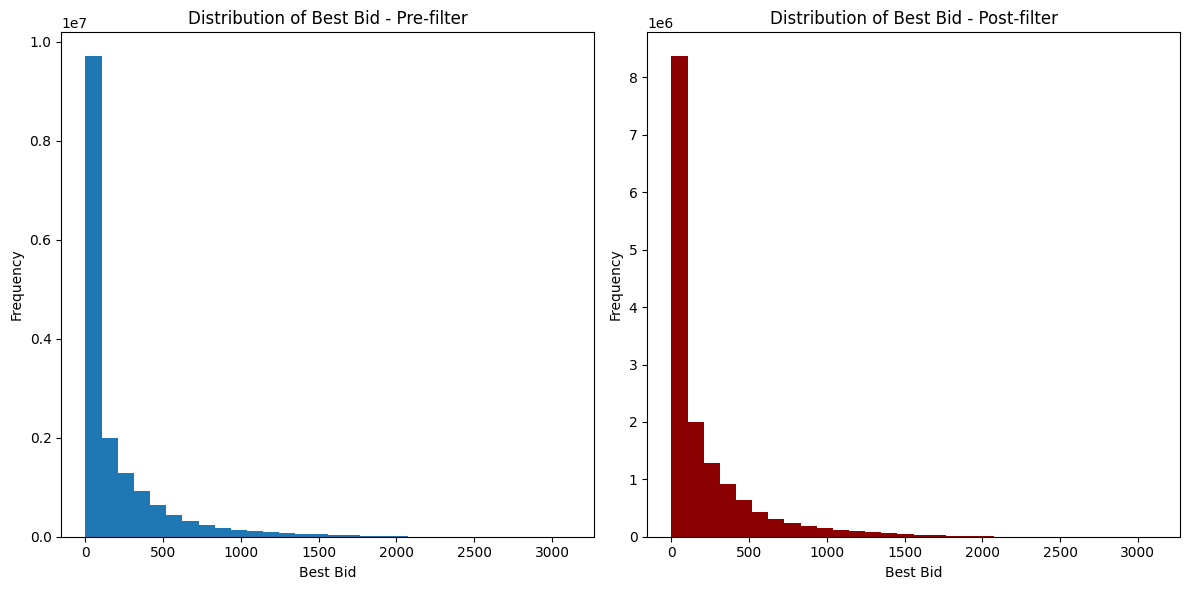

Need some better plots here...


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of best_bid for optm_l1_id
axes[0].hist(spx_filtered_2["best_bid"], bins=30)
axes[0].set_xlabel("Best Bid")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Best Bid - Pre-filter")

# Plot distribution of best_bid for optm_l1_zbid
axes[1].hist(spx_filtered_3["best_bid"], bins=30, color="darkred")
axes[1].set_xlabel("Best Bid")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Best Bid - Post-filter")

plt.tight_layout()
plt.show()
print("Need some better plots here...")

## Filter Options with Vol = 0

Table B.1 of *CJS 2013* appears to signal the inclusion of a Volume = 0 filter, however, Appendix B does not describe this filter. We note that there are a significant number of quotes with zero volume in our dataset, and the application of this filter would dramatically skew the results from the original dataset (with 70% of remaining records dropped using this criterion). Given that Appendix B of *CJS 2013* did not describe this filter, we assume its inclusion in Table B.1 was an error.

In [15]:
spx_filtered_4 = f1.delete_zero_volume_filter(spx_filtered_3)
compare_filtered_data_to_orig(
    spx_filtered_4, spx_filtered_3, "Delete Zero Volume Filter"
)

| Delete Zero Volume Filter :
>> Records removed: 10,570,785 out of 15,038,063 (70.29%)
>> Filtered data shape: 4,467,278 rows // 16 columns


In [16]:
spx_filtered_4 = spx_filtered_3.copy(deep=True)

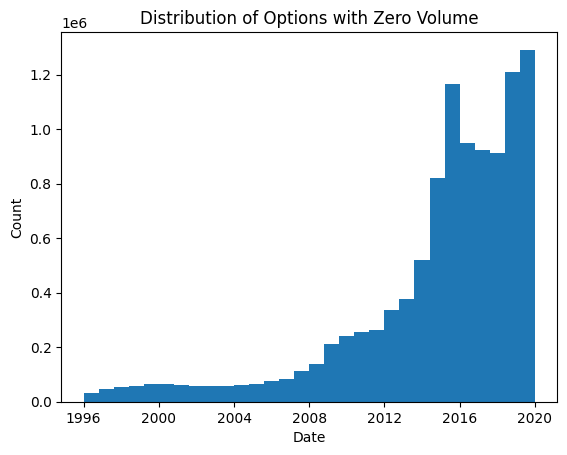

In [17]:
zero_vol_rows = spx_filtered_3[spx_filtered_3["volume"] == 0]
plt.hist(zero_vol_rows["date"], bins=30)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Distribution of Options with Zero Volume")
plt.show()

In [18]:
# save L1 filtered data
spx_l1_filtered = spx_filtered_4.copy(deep=True)
spx_l1_filtered.to_parquet(
    Path(DATA_DIR / "options" / f"L1_filtered_{DATE_RANGE}.parquet"), index=False
)

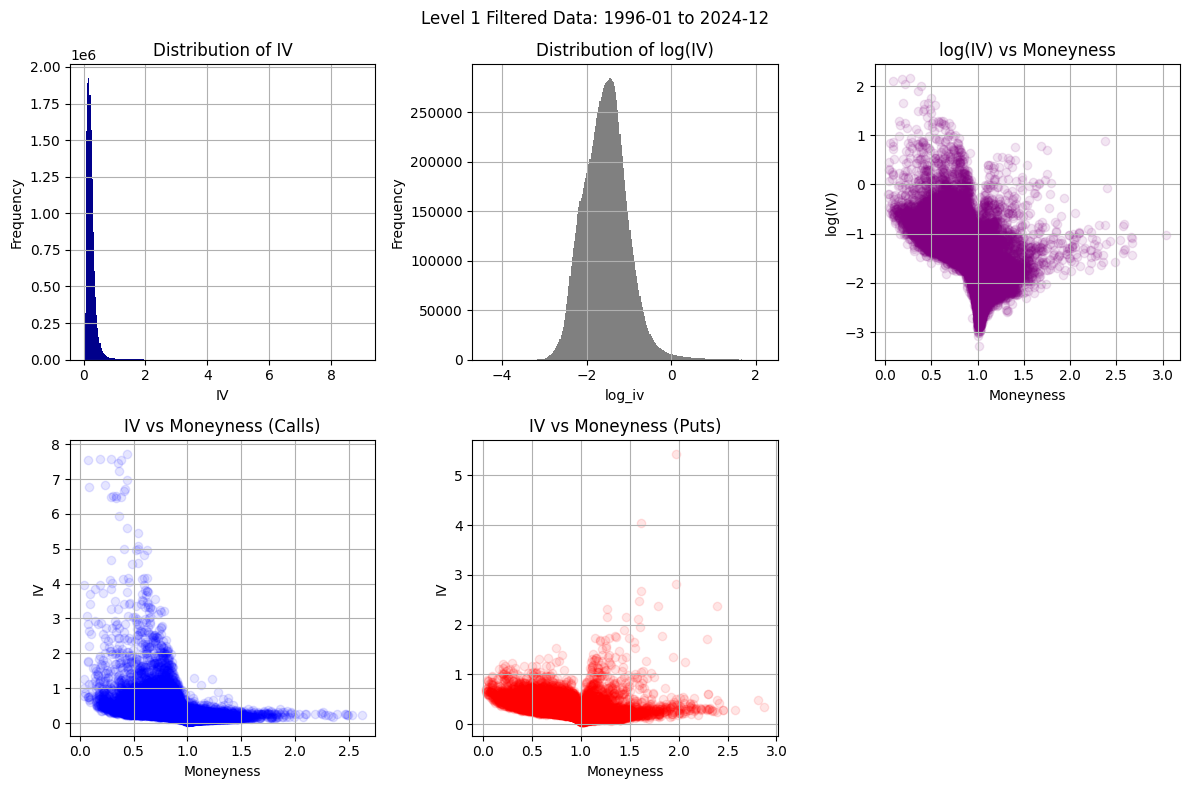

In [19]:
f3.build_l1_iv_chart(spx_l1_filtered, date_range=DATE_RANGE)

---

## Level 2 Filters


* **Days to Maturity <7 or >180 Filter:** Drop options with fewer than seven or more than 180 calendar days to expiration. 


* **IV<5% or >100% Filter:** We remove all option quotes with implied volatilities lower than 5% or higher than 100%, computed using T-bill interest rates.

* **Moneyness <0.8 or >1.2 Filter:** We remove all option quotes with moneyness, the ratio of strike price to index price, below 0.8 or above 1.2. These options have little value beyond their intrinsic value and are also very thinly traded.

* **Implied Interest Rate <0 Filter:** When filtering outliers, we use T-bill interest rates to compute implied volatilities. T-bill interest rates are obtained from the Federal Reserve’s H.15 release. We assign a T-bill rate to each observation by assuming that we can use the next shortest rate if the time to expiration of the option is shorter than the shortest constant maturity rate.
Our goal is to obtain an interest rate that is as close as possible to the one faced by investors in the options market. It appears that the T-bill rates are not the relevant ones when pricing these options. Specifically, when the T-bill rates are used, put and call implied volatilities do not line up very well; for example, the T-bill rate tends to be too high for short maturity options, perhaps because no T-bill has maturity of less than a month. To address these issues, we compute a put-call parity-implied interest rate. Since we believe that put-call parity holds reasonably well in this deep and liquid European options market, we use the put-call parity-implied interest rate as our interest rate in the remainder of the paper and for further filters. To construct this rate, we take all put-call pairs of a given maturity and impose put-call parity using the bid-ask midpoint as the price, and allowing the interest rate to adjust. We remove 89,563 pairs with a negative implied interest rate. We then take the median-implied interest rate across all remaining pairs of the same maturity with moneyness between 0.95 and 1.05 and assign it to all quotes with that maturity. We are able to directly assign an implied interest rate to 93% of our sample in this way. We fill in the gaps by interpolating across maturities and if necessary, across days. Our implied interest rate is on average 54 bps above the T-bill rate

* **Unable to Compute IV Filter:** We remove quotes that imply negative time
value.


### Days to Maturity <7 or >180 Filter

We drop records with days to maturity less than 7 and greater than 180 days. The short maturity options tend to move erratically close to expiration and the long maturity options lack volume and open interest.

In [20]:
spx_filtered_5 = f2.days_to_maturity_filter(spx_filtered_4, min_days=7, max_days=180)
spx_filtered_5

,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness,days_to_maturity
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,NaN,5.04,0.0,1704.0,55.00,56.00,565.0,100.0,55.50,0.914684,72 days
1,108105.0,1996-01-04,621.32,617.70,C,1996-01-20,NaN,5.04,0.0,108.0,75.50,76.50,540.0,100.0,76.00,0.874211,16 days
2,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,0.106792,5.04,150.0,5633.0,24.75,25.75,600.0,100.0,25.25,0.971345,72 days
3,108105.0,1996-01-04,621.32,617.70,C,1996-02-17,NaN,5.04,0.0,90.0,48.25,49.25,570.0,100.0,48.75,0.922778,44 days
4,108105.0,1996-01-04,621.32,617.70,C,1996-06-22,0.123411,5.04,0.0,195.0,38.50,39.50,595.0,100.0,39.00,0.963251,170 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379461,108105.0,2019-12-31,3215.18,3230.78,P,2020-01-17,0.426246,1.52,24.0,719.0,0.25,0.35,2545.0,100.0,0.30,0.787735,17 days
16379462,108105.0,2019-12-31,3215.18,3230.78,P,2020-02-21,0.188281,1.52,22.0,231.0,14.30,14.60,2985.0,100.0,14.45,0.923925,52 days
16379463,108105.0,2019-12-31,3215.18,3230.78,P,2020-03-20,0.234228,1.52,26.0,1003.0,8.50,8.70,2730.0,100.0,8.60,0.844997,80 days
16379464,108105.0,2019-12-31,3215.18,3230.78,P,2020-04-17,0.134421,1.52,0.0,651.0,92.90,93.80,3230.0,100.0,93.35,0.999759,108 days


In [21]:
compare_filtered_data_to_orig(spx_filtered_5, spx_filtered_4, "Days to Maturity Filter")

| Days to Maturity Filter :
>> Records removed: 4,378,590 out of 15,038,063 (29.12%)
>> Filtered data shape: 10,659,473 rows // 17 columns


### IV<5% or >100% Filter

We drop quotes with **implied volatilities lower than 5% or higher than 100%**, computed using T-bill interest rates of the nearest matching maturity. Such extreme IV values are likely a quotation problem or attached to low-value options.

In [22]:
spx_filtered_6 = f2.iv_range_filter(spx_filtered_5, min_iv=0.05, max_iv=1.0)
spx_filtered_6

,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness,days_to_maturity
2,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,0.106792,5.04,150.0,5633.0,24.750,25.750,600.0,100.0,25.250,0.971345,72 days
4,108105.0,1996-01-04,621.32,617.70,C,1996-06-22,0.123411,5.04,0.0,195.0,38.500,39.500,595.0,100.0,39.000,0.963251,170 days
6,108105.0,1996-01-04,621.32,617.70,C,1996-02-17,0.093700,5.04,13.0,1364.0,10.625,11.375,615.0,100.0,11.000,0.995629,44 days
7,108105.0,1996-01-04,621.32,617.70,C,1996-02-17,0.092695,5.04,0.0,1702.0,0.250,0.500,655.0,100.0,0.375,1.060385,44 days
10,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,0.101465,5.04,463.0,5037.0,9.125,9.875,625.0,100.0,9.500,1.011818,72 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379461,108105.0,2019-12-31,3215.18,3230.78,P,2020-01-17,0.426246,1.52,24.0,719.0,0.250,0.350,2545.0,100.0,0.300,0.787735,17 days
16379462,108105.0,2019-12-31,3215.18,3230.78,P,2020-02-21,0.188281,1.52,22.0,231.0,14.300,14.600,2985.0,100.0,14.450,0.923925,52 days
16379463,108105.0,2019-12-31,3215.18,3230.78,P,2020-03-20,0.234228,1.52,26.0,1003.0,8.500,8.700,2730.0,100.0,8.600,0.844997,80 days
16379464,108105.0,2019-12-31,3215.18,3230.78,P,2020-04-17,0.134421,1.52,0.0,651.0,92.900,93.800,3230.0,100.0,93.350,0.999759,108 days


In [23]:
compare_filtered_data_to_orig(spx_filtered_6, spx_filtered_5, "IV Range Filter")

| IV Range Filter :
>> Records removed: 1,072,612 out of 10,659,473 (10.06%)
>> Filtered data shape: 9,586,861 rows // 17 columns


### Moneyness <0.8 or >1.2 Filter

We remove all option quotes with moneyness ($\frac{K}{S}$) below 0.8 or above 1.2. These options have little value beyond their intrinsic value and are also very thinly traded.


In [24]:
spx_filtered_7 = f2.moneyness_filter(
    spx_filtered_6, min_moneyness=0.8, max_moneyness=1.2
)
spx_filtered_7

,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness,days_to_maturity
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,0.106792,5.04,150.0,5633.0,24.750,25.750,600.0,100.0,25.250,0.971345,72 days
1,108105.0,1996-01-04,621.32,617.70,C,1996-06-22,0.123411,5.04,0.0,195.0,38.500,39.500,595.0,100.0,39.000,0.963251,170 days
2,108105.0,1996-01-04,621.32,617.70,C,1996-02-17,0.093700,5.04,13.0,1364.0,10.625,11.375,615.0,100.0,11.000,0.995629,44 days
3,108105.0,1996-01-04,621.32,617.70,C,1996-02-17,0.092695,5.04,0.0,1702.0,0.250,0.500,655.0,100.0,0.375,1.060385,44 days
4,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,0.101465,5.04,463.0,5037.0,9.125,9.875,625.0,100.0,9.500,1.011818,72 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657970,108105.0,2019-12-31,3215.18,3230.78,P,2020-05-29,0.120268,1.52,0.0,0.0,561.300,575.500,3800.0,100.0,568.400,1.176187,150 days
7657971,108105.0,2019-12-31,3215.18,3230.78,P,2020-02-21,0.188281,1.52,22.0,231.0,14.300,14.600,2985.0,100.0,14.450,0.923925,52 days
7657972,108105.0,2019-12-31,3215.18,3230.78,P,2020-03-20,0.234228,1.52,26.0,1003.0,8.500,8.700,2730.0,100.0,8.600,0.844997,80 days
7657973,108105.0,2019-12-31,3215.18,3230.78,P,2020-04-17,0.134421,1.52,0.0,651.0,92.900,93.800,3230.0,100.0,93.350,0.999759,108 days


In [25]:
compare_filtered_data_to_orig(spx_filtered_7, spx_filtered_6, "Moneyness Filter")

| Moneyness Filter :
>> Records removed: 1,928,886 out of 9,586,861 (20.12%)
>> Filtered data shape: 7,657,975 rows // 17 columns


### Implied Interest Rate < 0 Filter

We remove all option quotes with negative implied interest rates, assuming put-call parity. 


In [26]:
spx_filtered_8 = f2.implied_interest_rate_filter(spx_filtered_7)
spx_filtered_8

 |-- PCP filter: Check ok --> Underlying prices, strike prices of put and call options match exactly.


,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness,days_to_maturity,pc_parity_int_rate
0,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.282774,5.04,8.0,6914.0,0.0625,0.1250,540.0,100.0,0.09375,0.874211,16 days,0.015898
1,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.265845,5.04,0.0,3897.0,0.0625,0.1250,545.0,100.0,0.09375,0.882305,16 days,0.015898
2,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.266303,5.04,0.0,3259.0,0.1250,0.1875,550.0,100.0,0.15625,0.890400,16 days,0.015898
3,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.255099,5.04,0.0,862.0,0.1250,0.2500,555.0,100.0,0.18750,0.898494,16 days,0.015898
4,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.247617,5.04,100.0,7438.0,0.1875,0.3125,560.0,100.0,0.25000,0.906589,16 days,0.015898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5137994,108105.0,2019-12-31,3215.18,3230.78,P,2020-06-19,0.110925,1.52,20.0,310.0,222.8000,228.9000,3425.0,100.0,225.85000,1.060116,171 days,0.014769
5137995,108105.0,2019-12-31,3215.18,3230.78,C,2020-06-19,0.108577,1.52,400.0,3483.0,24.6000,25.1000,3450.0,100.0,24.85000,1.067854,171 days,0.014769
5137996,108105.0,2019-12-31,3215.18,3230.78,P,2020-06-19,0.108540,1.52,0.0,12.0,241.2000,247.6000,3450.0,100.0,244.40000,1.067854,171 days,0.014769
5137997,108105.0,2019-12-31,3215.18,3230.78,C,2020-06-19,0.106848,1.52,36.0,227.0,19.6000,20.1000,3475.0,100.0,19.85000,1.075592,171 days,0.014769


In [27]:
compare_filtered_data_to_orig(
    spx_filtered_8, spx_filtered_7, "Negative Implied Interest Rate Filter"
)

| Negative Implied Interest Rate Filter :
>> Records removed: 2,519,976 out of 7,657,975 (32.91%)
>> Filtered data shape: 5,137,999 rows // 18 columns


### Unable to Compute IV Filter

We remove all option quotes that imply negative time value. 


In [28]:
spx_filtered_9 = f2.unable_to_compute_iv_filter(spx_filtered_8)
spx_filtered_9

,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness,days_to_maturity,pc_parity_int_rate,intrinsic
0,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.282774,5.04,8.0,6914.0,0.0625,0.1250,540.0,100.0,0.09375,0.874211,16 days,0.015898,0.00
1,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.265845,5.04,0.0,3897.0,0.0625,0.1250,545.0,100.0,0.09375,0.882305,16 days,0.015898,0.00
2,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.266303,5.04,0.0,3259.0,0.1250,0.1875,550.0,100.0,0.15625,0.890400,16 days,0.015898,0.00
3,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.255099,5.04,0.0,862.0,0.1250,0.2500,555.0,100.0,0.18750,0.898494,16 days,0.015898,0.00
4,108105.0,1996-01-04,621.32,617.70,P,1996-01-20,0.247617,5.04,100.0,7438.0,0.1875,0.3125,560.0,100.0,0.25000,0.906589,16 days,0.015898,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5137994,108105.0,2019-12-31,3215.18,3230.78,P,2020-06-19,0.110925,1.52,20.0,310.0,222.8000,228.9000,3425.0,100.0,225.85000,1.060116,171 days,0.014769,194.22
5137995,108105.0,2019-12-31,3215.18,3230.78,C,2020-06-19,0.108577,1.52,400.0,3483.0,24.6000,25.1000,3450.0,100.0,24.85000,1.067854,171 days,0.014769,0.00
5137996,108105.0,2019-12-31,3215.18,3230.78,P,2020-06-19,0.108540,1.52,0.0,12.0,241.2000,247.6000,3450.0,100.0,244.40000,1.067854,171 days,0.014769,219.22
5137997,108105.0,2019-12-31,3215.18,3230.78,C,2020-06-19,0.106848,1.52,36.0,227.0,19.6000,20.1000,3475.0,100.0,19.85000,1.075592,171 days,0.014769,0.00


In [29]:
compare_filtered_data_to_orig(
    spx_filtered_9, spx_filtered_8, "Unable to Compute IV Filter"
)

| Unable to Compute IV Filter :
>> Records removed: 480,523 out of 5,137,999 (9.35%)
>> Filtered data shape: 4,657,476 rows // 19 columns


In [30]:
# save L2 filtered data
spx_l2_filtered = spx_filtered_9.copy(deep=True)
spx_l2_filtered.to_parquet(
    Path(DATA_DIR / "options" / f"L2_filtered_{DATE_RANGE}.parquet"), index=False
)

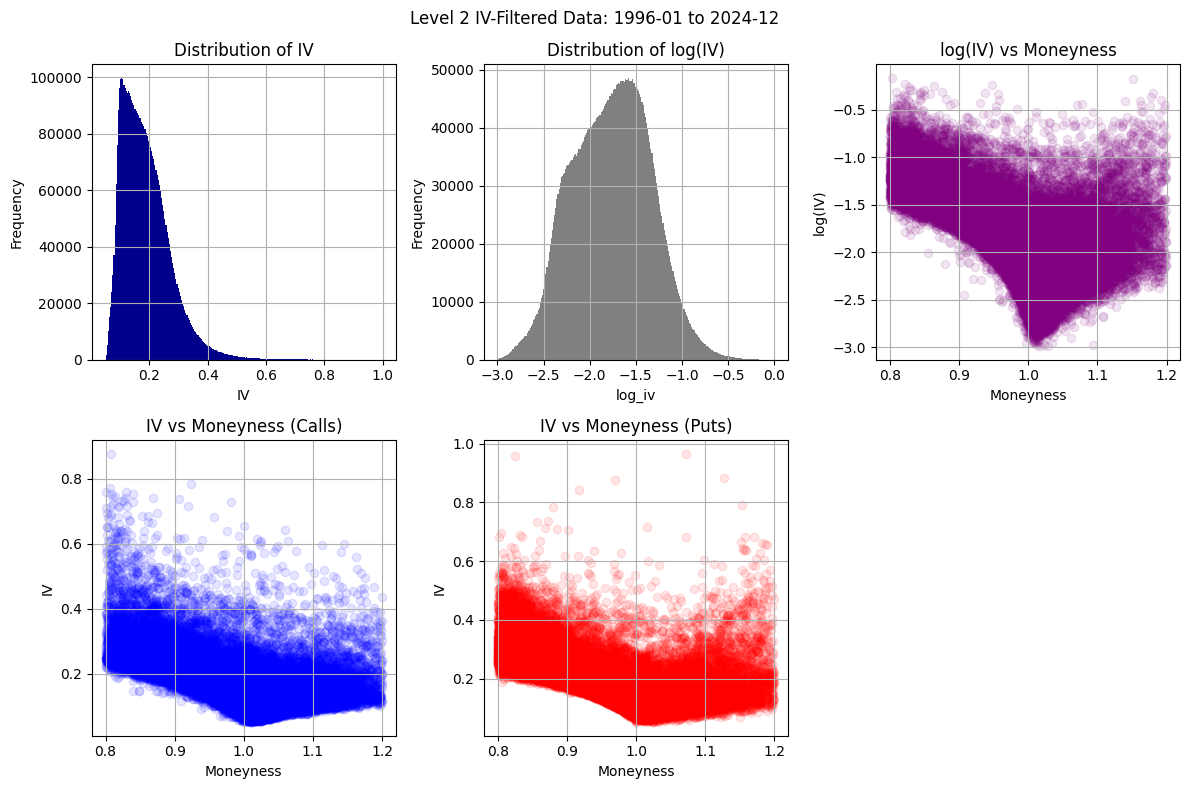

In [31]:
f3.build_l2_iv_chart(spx_l2_filtered, date_range=DATE_RANGE)

---

## Level 3 Filters


* **IV Filter:** The IV filter removes volatility outliers to reduce the prevalence of apparent butterfly arbitrage. 

* **Put-Call Parity Filter:** The puts and calls need to be matched up based on trading date, expiry date, and option type.


### IV Filter

The IV filter removes volatility outliers to reduce the prevalence of apparent butterfly arbitrage. This involves dropping calls and puts that have the same expiration date and strike price, but have anomalous prices due to extreme implied volatility values. For each *date* and *maturity*, we fit a quadratic curve to the implied volatility of puts and calls (separately) through the observed log implied volatilities.

In [32]:
l2_data_with_fit, spx_filtered_10 = f3.IV_filter(spx_filtered_9, DATE_RANGE)
spx_filtered_10

 
>> Running IV filter...
 |-- IV filter: applying quadratic fit...


 |-- !! Execution time: apply_quadratic_iv_fit --> 26.82598 seconds
 |-- IV filter: filtering outliers...


 |-- IV filter: saving L3 IV-filtered data...


secid       date     open    close  \
date       exdate     cp_flag                                                  
1996-01-04 1996-01-20 C       14       108105.0 1996-01-04   621.32   617.70   
                              16       108105.0 1996-01-04   621.32   617.70   
                              18       108105.0 1996-01-04   621.32   617.70   
                              20       108105.0 1996-01-04   621.32   617.70   
                              22       108105.0 1996-01-04   621.32   617.70   
...                                         ...        ...      ...      ...   
2019-12-31 2020-06-19 P       5137990  108105.0 2019-12-31  3215.18  3230.78   
                              5137992  108105.0 2019-12-31  3215.18  3230.78   
                              5137994  108105.0 2019-12-31  3215.18  3230.78   
                              5137996  108105.0 2019-12-31  3215.18  3230.78   
                              5137998  108105.0 2019-12-31  3215.18  3230.78   

                                      cp_flag     exdate        IV  tb_m3  \
date       exdate     cp_flag                                               
1996-01-04 1996-01-20 C       14            C 1996-01-20  0.082711   5.04   
                              16            C 1996-01-20  0.109019   5.04   
                              18            C 1996-01-20  0.101986   5.04   
                              20            C 1996-01-20  0.097356   5.04   
                              22            C 1996-01-20  0.101756   5.04   
...                                       ...        ...       ...    ...   
2019-12-31 2020-06-19 P       5137990       P 2020-06-19  0.117063   1.52   
                              5137992       P 2020-06-19  0.113900   1.52   
                              5137994       P 2020-06-19  0.110925   1.52   
                              5137996       P 2020-06-19  0.108540   1.52   
                              5137998       P 2020-06-19  0.106814   1.52   

                                       volume  open_interest  best_bid  \
date       exdate     cp_flag                                            
1996-01-04 1996-01-20 C       14        444.0         5905.0   10.0000   
                              16        465.0         4270.0    7.5000   
                              18       2606.0         6635.0    4.5000   
                              20       4022.0         5969.0    1.1875   
                              22       1627.0         6224.0    0.6250   
...                                       ...            ...       ...   
2019-12-31 2020-06-19 P       5137990     0.0          395.0  192.2000   
                              5137992     0.0          163.0  208.2000   
                              5137994    20.0          310.0  222.8000   
                              5137996     0.0           12.0  241.2000   
                              5137998     0.0            0.0  260.9000   

                                       best_offer  strike_price  \
date       exdate     cp_flag                                     
1996-01-04 1996-01-20 C       14           10.375         610.0   
                              16            8.000         615.0   
                              18            4.875         620.0   
                              20            1.375         630.0   
                              22            0.750         635.0   
...                                           ...           ...   
2019-12-31 2020-06-19 P       5137990     193.000        3375.0   
                              5137992     209.100        3400.0   
                              5137994     228.900        3425.0   
                              5137996     247.600        3450.0   
                              5137998     267.500        3475.0   

                                       contract_size  mid_price  moneyness  \
date       exdate     cp_flag                                                
1996-01-

In [33]:
compare_filtered_data_to_orig(spx_filtered_10, spx_filtered_9, "IV Filter")

| IV Filter :
>> Records removed: 356,135 out of 4,657,476 (7.65%)
>> Filtered data shape: 4,301,341 rows // 25 columns


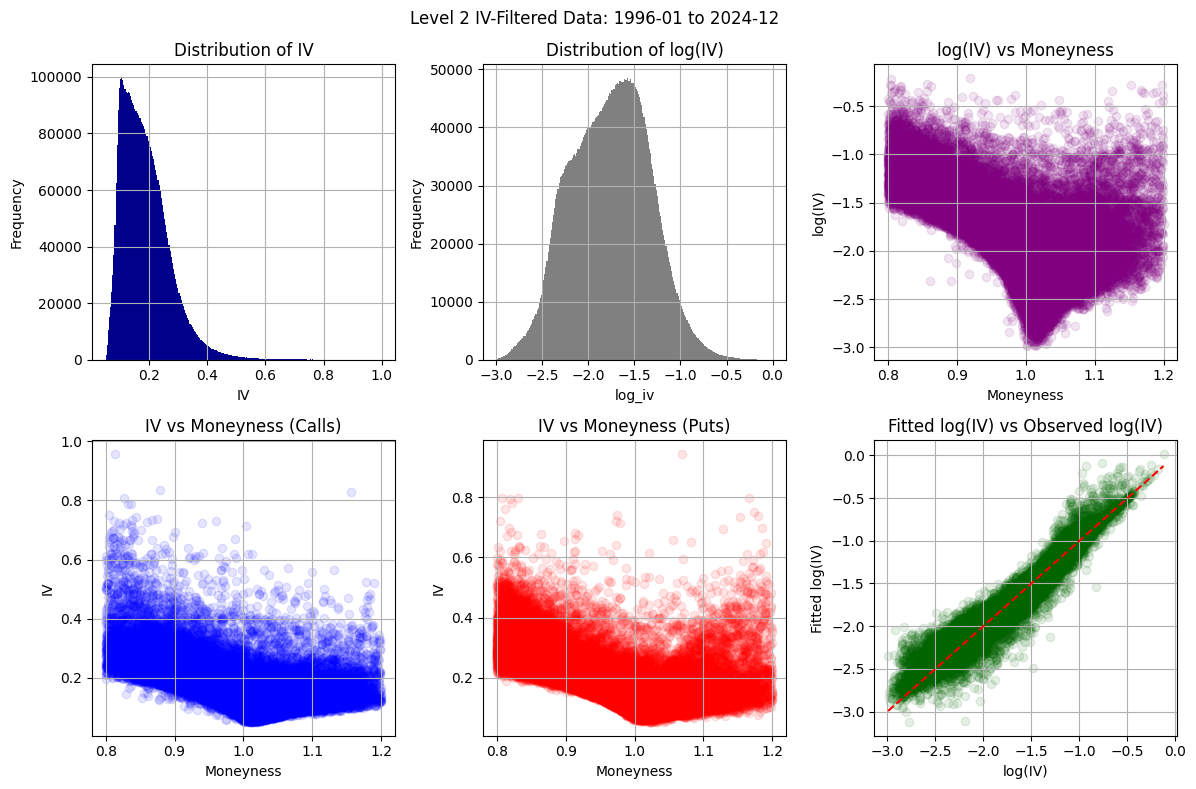

In [34]:
f3.build_l2_iv_chart(l2_data_with_fit, date_range=DATE_RANGE)

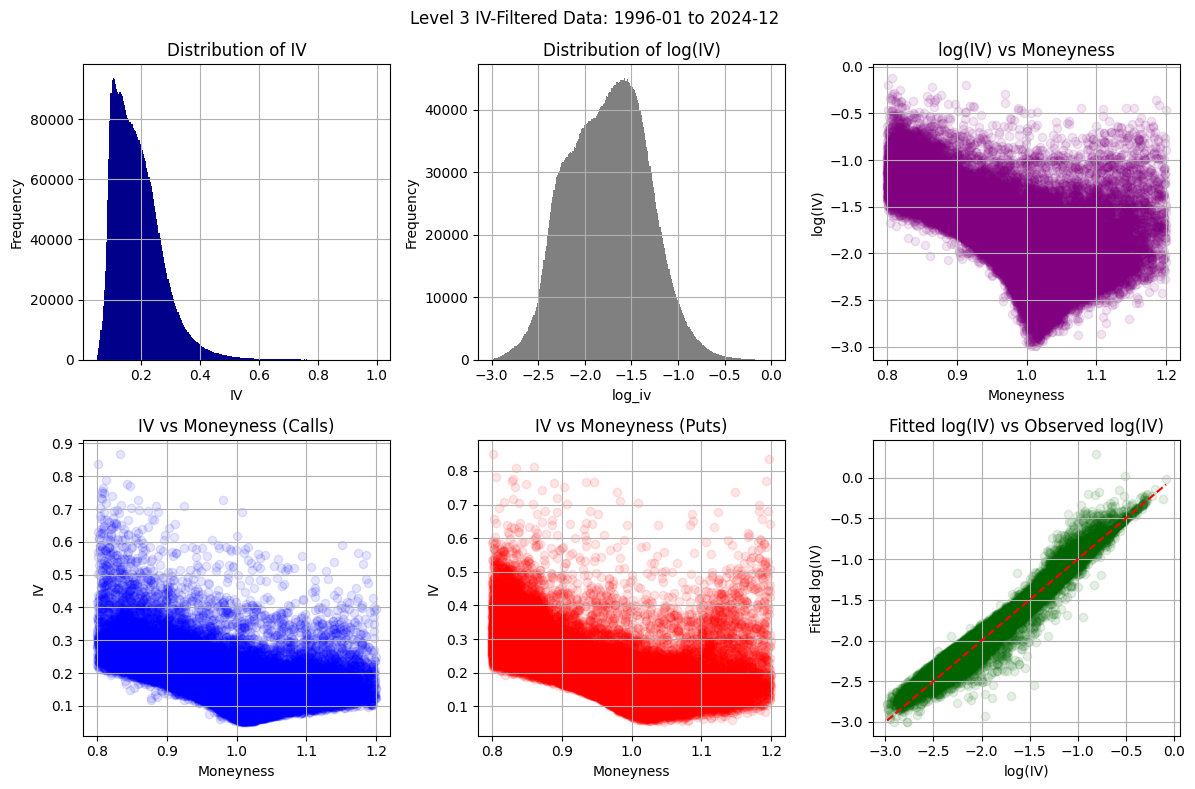

In [35]:
f3.build_l3_iv_chart(spx_filtered_10, DATE_RANGE)

### Put-Call Parity Filter

The puts and calls need to be matched up based on trading date, expiry date, and option type. We then calculate the put-call parity implied interest rate, and filter out outliers based on the standard deviation of the relative distance between the interest rate implied by put-call parity, and the calculated daily median 3-month T-bill rate from the pulled data.

In [36]:
spx_filtered_11 = f3.put_call_filter(spx_filtered_10, DATE_RANGE)
spx_filtered_11

 
>> Running PCP filter...
 |-- PCP filter: calculating bid-ask midpoint...


 |-- PCP filter: building put-call pairs...


 |-- PCP filter: calculating PCP implied interest rate...
 |-- PCP filter: Check ok --> Underlying prices, strike prices of put and call options match exactly.


 |-- PCP filter: filtering outliers...


 |-- PCP filter: building L3 final filtered options chart...
 |-- PCP filter complete.


secid     open    close cp_flag        IV  \
date       exdate     moneyness                                                 
1996-01-04 1996-01-20 0.987534   108105.0   621.32   617.70       C  0.082711   
                      1.019913   108105.0   621.32   617.70       C  0.097356   
                      1.028007   108105.0   621.32   617.70       C  0.101756   
                      1.036102   108105.0   621.32   617.70       C  0.100588   
           1996-02-17 0.963251   108105.0   621.32   617.70       C  0.071852   
...                                   ...      ...      ...     ...       ...   
2019-12-31 2020-06-19 1.044639   108105.0  3215.18  3230.78       P  0.117063   
                      1.052377   108105.0  3215.18  3230.78       P  0.113900   
                      1.060116   108105.0  3215.18  3230.78       P  0.110925   
                      1.067854   108105.0  3215.18  3230.78       P  0.108540   
                      1.075592   108105.0  3215.18  3230.78       P  0.106814   

                                 tb_m3  volume  open_interest  best_bid  \
date       exdate     moneyness                                           
1996-01-04 1996-01-20 0.987534    5.04   444.0         5905.0   10.0000   
                      1.019913    5.04  4022.0         5969.0    1.1875   
                      1.028007    5.04  1627.0         6224.0    0.6250   
                      1.036102    5.04     0.0         6593.0    0.1875   
           1996-02-17 0.963251    5.04     3.0           34.0   25.2500   
...                                ...     ...            ...       ...   
2019-12-31 2020-06-19 1.044639    1.52     0.0          395.0  192.2000   
                      1.052377    1.52     0.0          163.0  208.2000   
                      1.060116    1.52    20.0          310.0  222.8000   
                      1.067854    1.52     0.0           12.0  241.2000   
                      1.075592    1.52     0.0            0.0  260.9000   

                                 best_offer  strike_price  contract_size  \
date       exdate     moneyness                                            
1996-01-04 1996-01-20 0.987534       10.375         610.0          100.0   
                      1.019913        1.375         630.0          100.0   
                      1.028007        0.750         635.0          100.0   
                      1.036102        0.375         640.0          100.0   
           1996-02-17 0.963251       26.250         595.0          100.0   
...                                     ...           ...            ...   
2019-12-31 2020-06-19 1.044639      193.000        3375.0          100.0   
                      1.052377      209.100        3400.0          100.0   
                      1.060116      228.900        3425.0          100.0   
                      1.067854      247.600        3450.0          100.0   
                      1.075592      267.500        3475.0          100.0   

                                 mid_price days_to_maturity  \
date       exdate     moneyness                               
1996-01-04 1996-01-20 0.987534    10.18750          16 days   
                      1.019913     1.28125          16 days   
                      1.028007     0.68750          16 days   
                      1.036102     0.28125          16 days   
           1996-02-17 0.963251    25.75000          44 days   
...                                    ...              ...   
2019-12-31 2020-06-19 1.044639   192.60000         171 days   
                      1.052377   208.65000         171 days   
                      1.060116   225.85000         171 days   
                      1.067854   244.40000         171 days   
                      1.075592   264.20000         171 days   

                                 pc_parity_int_rate  intrinsic    log_iv  \
date       exdate     moneyness                                            
1996-01-04 1996-01-20 0.987534             0.

In [37]:
compare_filtered_data_to_orig(
    spx_filtered_11, spx_filtered_10, "Put-Call Parity Filter"
)

| Put-Call Parity Filter :
>> Records removed: 1,105,455 out of 4,301,341 (25.70%)
>> Filtered data shape: 3,195,886 rows // 22 columns


In [38]:
# save L3 filtered data
spx_l3_filtered = spx_filtered_11.copy(deep=True)
spx_l3_filtered.to_parquet(
    Path(DATA_DIR / "options" / f"L3_filtered_{DATE_RANGE}.parquet"), index=False
)

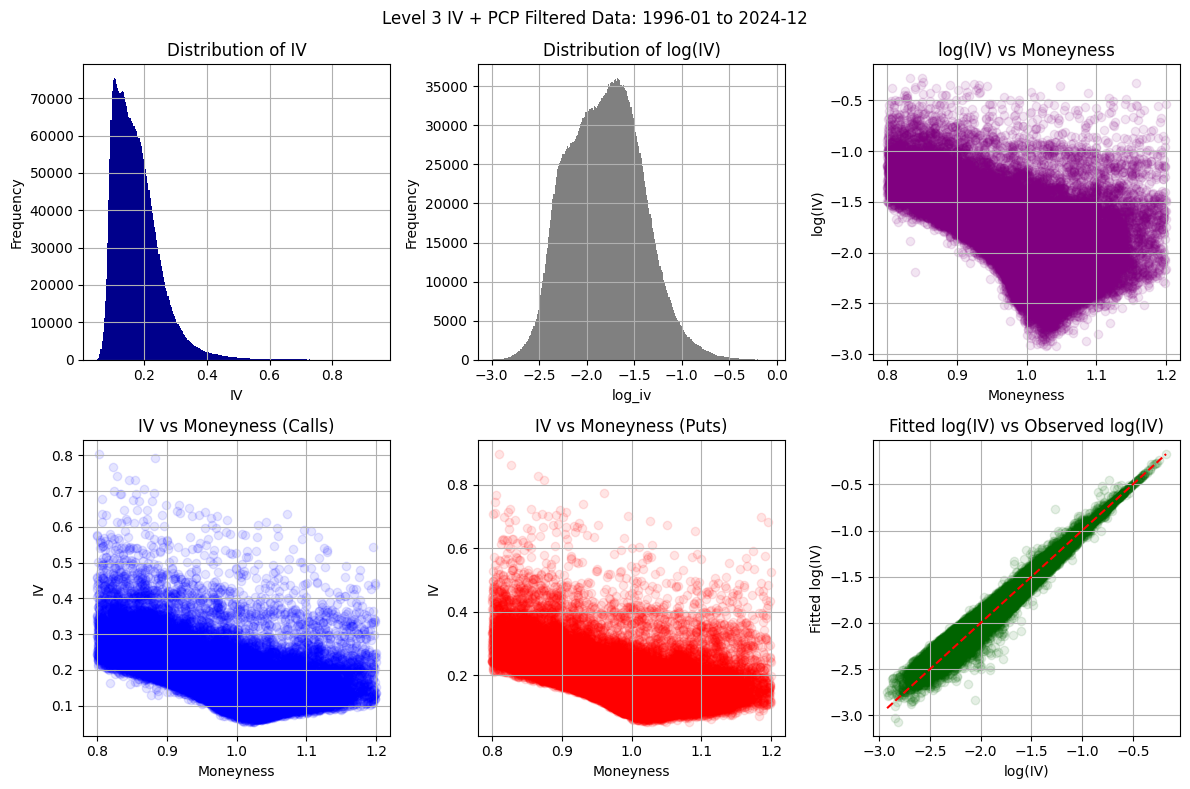

In [39]:
f3.build_l3_iv_pcp_chart(spx_l3_filtered, DATE_RANGE)

In [40]:
# save final cleaned data to folder
spx_filtered_final = spx_filtered_11.copy(deep=True)

final_savefile = DATA_DIR / "options" / f"spx_filtered_final_{DATE_RANGE}.parquet"

try:
    spx_filtered_final.to_parquet(final_savefile, index=True)
    print(f">> Final filtered data saved to {final_savefile}")
except FileNotFoundError:
    print(f">> {DATA_DIR} does not exist. Creating directory...")
    os.makedirs(DATA_DIR, exist_ok=True)
    spx_filtered_final.to_parquet(final_savefile, index=True)
    print(f">> Final filtered data saved to {final_savefile}")

>> Final filtered data saved to /Users/jbejarano/GitRepositories/ftsfr/_data/options/spx_filtered_final_1996-01_2024-12.parquet


----